# In colab?

In [1]:
try:
  from google.colab import files
  IN_COLAB = True
except:
  IN_COLAB = False

# Imports

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.io as sio
from scipy.stats import qmc
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras import layers

In [3]:
rng = np.random.default_rng()

# Introduction

See:
Article (Raissi2017)
Raissi, M.; Perdikaris, P. & Karniadakis, G. E.
Physics Informed Deep Learning (Part I): Data-driven Solutions of Nonlinear Partial Differential Equations

For small values of the viscosity parameters, Burgers’ equation can lead to shock formation that is notoriously hard to resolve by classical numerical methods. In one space dimension, the Burger’s equation along with Dirichlet boundary conditions reads as

\begin{align}
& u_t + uu_x - (0.01/\pi)u_{xx} = 0,\quad x \in [-1, 1],\quad t \in [0, 1], \\
& u(0, x) = -\sin(\pi x), \\
& u(t, -1) = u(t, 1) = 0.
\end{align}

# Parameters

In [4]:
ν = 0.01  # Viscosity in Burgers' equation
π = np.pi
N_u = 100  # Initial and boundary condition points
N_f = 10_000  # f collocation points

# Exact solution

In [5]:
if IN_COLAB:
  print("Upload burgers_shock.mat")
  files.upload()
  data = sio.loadmat("burgers_shock.mat")
else:
  data = sio.loadmat("../data/burgers_shock.mat")

Upload burgers_shock.mat


Saving burgers_shock.mat to burgers_shock (4).mat


In [6]:
x = data['x']
t = data['t']
u = data['usol']

In [7]:
x.shape, t.shape, u.shape

((256, 1), (100, 1), (256, 100))

In [8]:
t, x = np.meshgrid(t, x)

In [9]:
t.shape, x.shape

((256, 100), (256, 100))

In [10]:
# In grid format, origin is top left.
# So, `x` increases from top to bottom.
# Let's flip `x` and `u` upside down to make lower left origin.
# This will match the figure 1 given in the paper
x = np.flipud(x)
u = np.flipud(u)

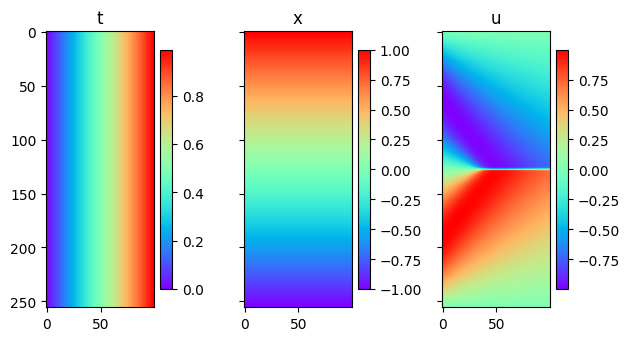

In [11]:
# Let's confirm, we are in the agreement with the figure 1 of the paper
_, axs = plt.subplots(1, 3, sharey=True)
for ax, val, name in zip(axs, (t, x, u), ('t', 'x', 'u')):
  im = ax.imshow(val, cmap="rainbow")
  ax.set_title(name)
  plt.colorbar(im, ax=ax, fraction=0.095)
plt.tight_layout()
plt.show()

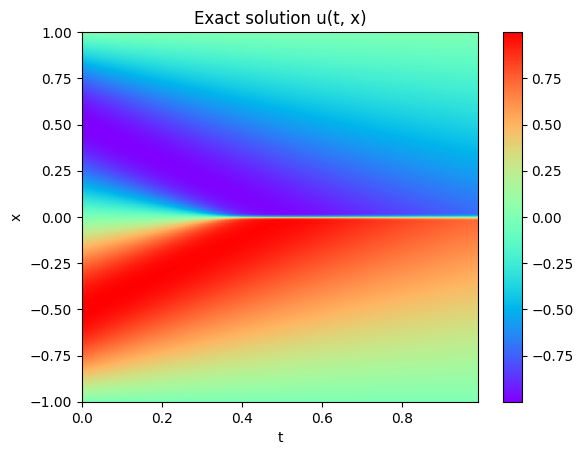

In [12]:
# Let's reproduce figure 1 of the paper for true solution
# and no training data points
plt.imshow(u, cmap="rainbow", aspect="auto",
           # extent = (left, right, bottom, top)
           extent=(t[-1, 0], t[-1, -1], x[-1, 0], x[0, 0]))
plt.title("Exact solution u(t, x)")
plt.xlabel('t')
plt.ylabel('x')
plt.colorbar()
plt.show()

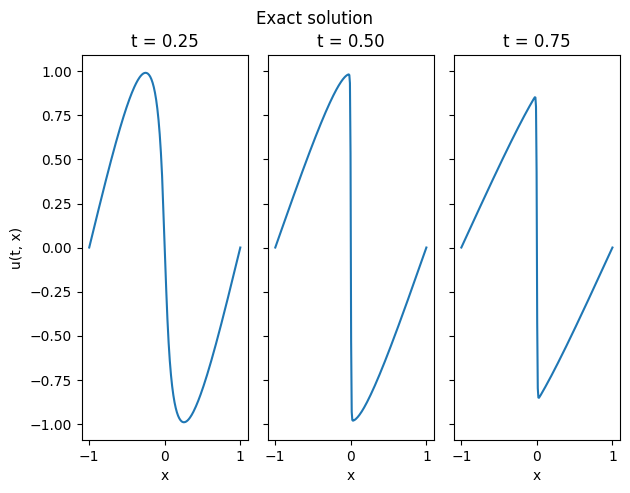

In [13]:
# Let's reproduce the bottom row of the figure also,
# again for the true solution only.
_, axs = plt.subplots(1, 3, sharey=True)
for ax, col in zip(axs, (25, 50, 75)):
  ax.plot(x[:, col], u[:, col])
  ax.set_xlabel("x")
  ax.set_title(f"t = {col/100:.2f}")
axs[0].set_ylabel("u(t, x)")
plt.tight_layout()
plt.suptitle("Exact solution", va="bottom")
plt.show()

# Training points

## Initial and boundary condition points

In [14]:
# Coordinates at the boundary, including initial condition
x_b = np.vstack((x[:1, :].T, x[:, :1], x[-1:, :].T))
t_b = np.vstack((t[:1, :].T, t[:, :1], t[-1:, :].T))
tx_b = np.hstack((t_b, x_b))

In [15]:
# Solution at the boundary, including initial condition
u_b = np.vstack((u[:1, :].T, u[:, :1], u[-1:, :].T))

In [16]:
# Let's randomly select `N_u` points for training purpose
idx = rng.choice(len(u_b), size=N_u, replace=False, shuffle=False)

In [17]:
tx_train = tx_b[idx]
u_train = u_b[idx]

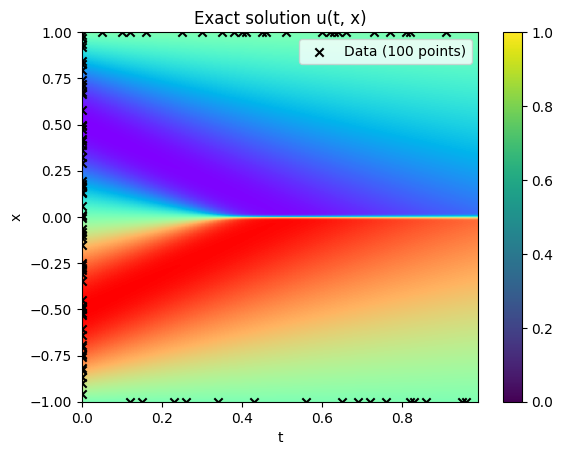

In [18]:
# Let's visualize training data points,
# just like the top row of figure 1 in the paper
plt.imshow(u, cmap="rainbow", aspect="auto",
           # extent = (left, right, bottom, top)
           extent=(t[-1, 0], t[-1, -1], x[-1, 0], x[0, 0]))
plt.scatter(tx_train[:, 0], tx_train[:, 1], marker='x', c='k',
            label=f"Data ({len(tx_train)} points)")
plt.title("Exact solution u(t, x)")
plt.legend()
plt.xlabel('t')
plt.ylabel('x')
plt.colorbar()
plt.show()

## Collocation points for f(t, x)

In [19]:
# Sample (t, x) in the domain using Latin hypercube sampling (LHS)
# Dimension of the parameter space is 2: (t, x)
sampler = qmc.LatinHypercube(d=2)
tx_f = sampler.random(n=N_f)
# Original samples are in the range [0, 1).
# Scale them to the desired lower and upper bounds
tx_f = qmc.scale(tx_f, (t.min(), x.min()), (t.max(), x.max()))

In [20]:
# Evaluate f(t, x) on the boundary points also
tx_f = np.vstack((tx_f, tx_train))

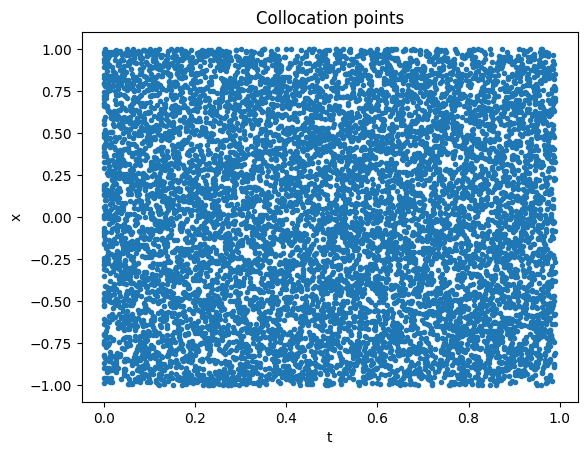

In [21]:
plt.scatter(tx_f[:, 0], tx_f[:, 1], marker=".")
plt.xlabel('t')
plt.ylabel('x')
plt.title("Collocation points")
plt.show()

# Model architecture

In [22]:
num_hidden_layers = 8
activation = "tanh"
units = 20

In [23]:
model = keras.Sequential([])
model.add(keras.Input(2, ))  # Input layer of shape (2, )
for _ in range(num_hidden_layers):  # Add hidden layers
  model.add(layers.Dense(units, activation=activation))
model.add(layers.Dense(units=1))  # Add the output layer

# Custom loss

In [24]:
t_tf = tf.constant(tx_f[:, :1].astype("float32"))
x_tf = tf.constant(tx_f[:, 1:].astype("float32"))

In [25]:
def custom_loss(y_true, y_pred):
  MSE_u = keras.losses.mean_squared_error(y_true, y_pred)
  with tf.GradientTape(persistent=True) as tape:
    tape.watch(t_tf)
    tape.watch(x_tf)
    u = model(tf.concat([t_tf, x_tf], axis=1))
    du_dx = tape.gradient(u, x_tf)
  du_dt = tape.gradient(u, t_tf)
  d2u_dx2 = tape.gradient(du_dx, x_tf)
  del tape
  f = du_dt + u*du_dx - (ν/π)*d2u_dx2  # Burgers' equation
  MSE_f = tf.reduce_mean(tf.square(f))

  return MSE_u + MSE_f

# Training

In [26]:
epochs = 5000

In [27]:
model.compile(loss=custom_loss,
              optimizer="rmsprop",
              metrics=["mae"])

In [28]:
hist = model.fit(tx_train,
                 u_train,
                 validation_split=0.2,
                 epochs=epochs,
                 verbose=1)

Epoch 1/5000


Streaming output truncated to the last 5000 lines.
3/3 [==============================] - 0s 42ms/step - loss: 0.0152 - mae: 0.0397 - val_loss: 0.0088 - val_mae: 0.0318
Epoch 2502/5000
3/3 [==============================] - 0s 39ms/step - loss: 0.0072 - mae: 0.0384 - val_loss: 0.0055 - val_mae: 0.0340
Epoch 2503/5000
3/3 [==============================] - 0s 43ms/step - loss: 0.0052 - mae: 0.0369 - val_loss: 0.0076 - val_mae: 0.0381
Epoch 2504/5000
3/3 [==============================] - 0s 39ms/step - loss: 0.0103 - mae: 0.0473 - val_loss: 0.0209 - val_mae: 0.0466
Epoch 2505/5000
3/3 [==============================] - 0s 38ms/step - loss: 0.0200 - mae: 0.0516 - val_loss: 0.0179 - val_mae: 0.0471
Epoch 2506/5000
3/3 [==============================] - 0s 43ms/step - loss: 0.0221 - mae: 0.0549 - val_loss: 0.0091 - val_mae: 0.0405
Epoch 2507/5000
3/3 [==============================] - 0s 33ms/step - loss: 0.0065 - mae: 0.0361 - val_loss: 0.0070 - val_mae: 0.0295
Epoch 2508/5000
3/3 [======

In [29]:
loss = hist.history['loss']
val_loss = hist.history['val_loss']
mae = hist.history['mae']
val_mae = hist.history['val_mae']
epochs = range(1, len(loss)+1)

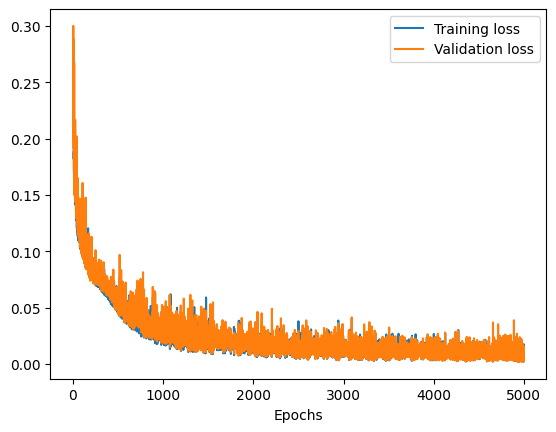

In [30]:
plt.plot(epochs, loss, label="Training loss")
plt.plot(epochs, val_loss, label="Validation loss")
plt.xlabel('Epochs')
plt.legend()
if IN_COLAB:
  plt.savefig("Burgers_loss.png")
else:
  plt.savefig("../images/Burgers_loss.png")
plt.show()

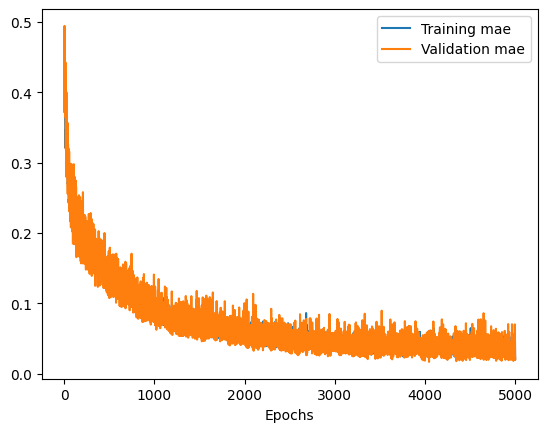

In [31]:
plt.plot(epochs, mae, label="Training mae")
plt.plot(epochs, val_mae, label="Validation mae")
plt.xlabel('Epochs')
plt.legend()
if IN_COLAB:
  plt.savefig("Burgers_mae.png")
else:
  plt.savefig("../images/Burgers_mae.png")
plt.show()

# Save and load model

In [32]:
if IN_COLAB:
  model_path = "Burgers.keras"
else:
  model_path =  "../models/Burgers.keras"

In [33]:
model.save(model_path)

In [34]:
model = keras.models.load_model(model_path, custom_objects={'custom_loss': custom_loss})

# Inference

In [35]:
t_vec = t.reshape(-1, 1)
x_vec = x.reshape(-1, 1)

In [36]:
u_pred = model.predict(np.hstack((t_vec, x_vec)))

800/800 [==============================] - 2s 3ms/step


In [37]:
u_pred = u_pred.reshape(256, 100)

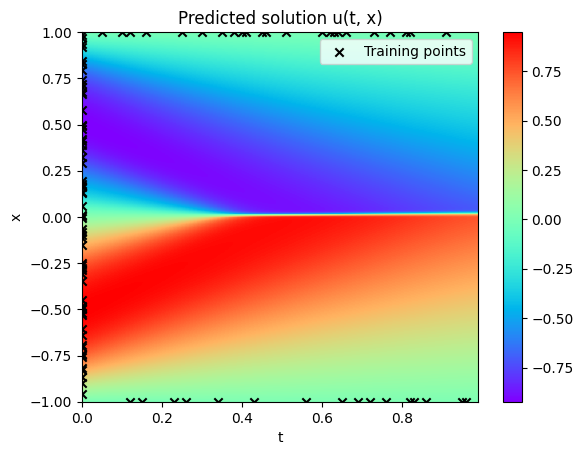

In [38]:
plt.imshow(u_pred, aspect="auto", cmap="rainbow",
           # extent = (left, right, bottom, top)
           extent=(t[-1, 0], t[-1, -1], x[-1, 0], x[0, 0]))
plt.colorbar()
plt.scatter(tx_train[:, 0], tx_train[:, 1], marker='x', c='k',
            label="Training points")
plt.title("Predicted solution u(t, x)")
plt.xlabel('t')
plt.ylabel('x')
plt.legend()
plt.show()

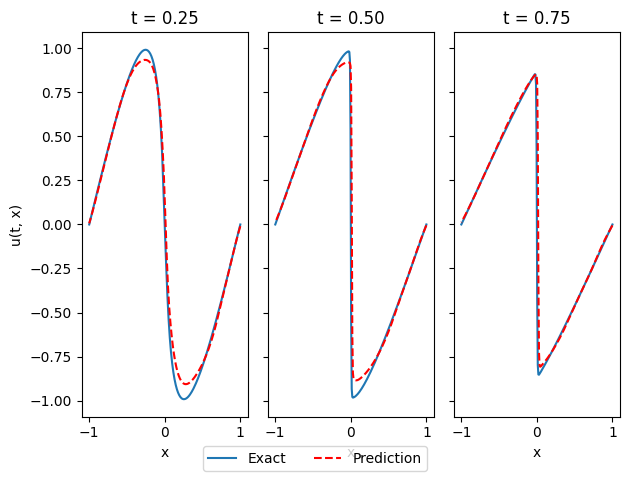

In [39]:
_, axs = plt.subplots(1, 3, sharey=True)
for ax, col in zip(axs, (25, 50, 75)):
  l1, = ax.plot(x[:, col], u[:, col])
  l2, = ax.plot(x[:, col], u_pred[:, col], "--r")
  ax.set_xlabel("x")
  ax.set_title(f"t = {col/100:.2f}")
axs[0].set_ylabel("u(t, x)")
plt.figlegend((l1, l2), ("Exact", "Prediction"), loc = 'lower center', ncol=2, labelspacing=0.)
plt.tight_layout()
plt.show()

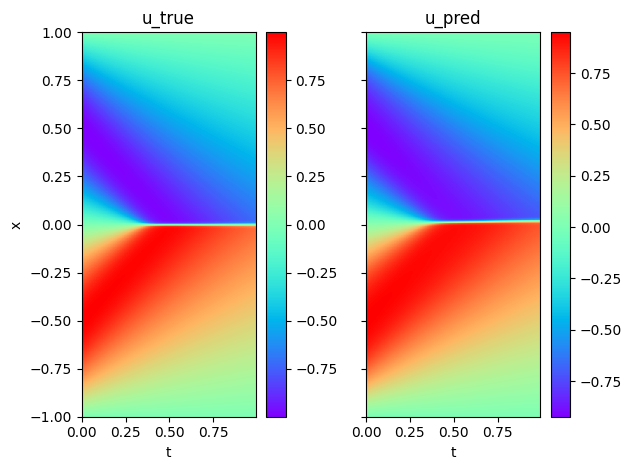

In [40]:
_, axs = plt.subplots(1, 2, sharey=True)
for ax, var, title in zip(axs, (u, u_pred), ("u_true", "u_pred")):
  im = ax.imshow(var, aspect="auto", cmap="rainbow",
                 # extent = (left, right, bottom, top)
                 extent=(t[-1, 0], t[-1, -1], x[-1, 0], x[0, 0]))
  plt.colorbar(im)
  ax.set_title(title)
  ax.set_xlabel("t")
axs[0].set_ylabel("x")
plt.tight_layout()
plt.show()
